Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. (10 баллов)

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. (35 баллов)

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

In [116]:
# Импорт библиотек:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from datetime import timedelta

from scipy import stats

import requests
from urllib.parse import urlencode

import warnings
warnings.filterwarnings('ignore')

plt.style.use('Solarize_Light2')

sns.set( font_scale = 2,
       style = 'whitegrid',
       rc = {'figure.figsize':(20,7)})

%matplotlib inline

In [39]:
# Импортируем датасеты:
customers = pd.read_csv('olist_customers_dataset.csv', parse_dates=True)
orders = pd.read_csv('olist_orders_dataset.csv', parse_dates=True)
order_items = pd.read_csv('olist_order_items_dataset.csv', parse_dates=True)

In [40]:
# Оценим наши данные:

In [41]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [42]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [43]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [44]:
# Приведем все колонки с временем к удобному типу:

In [45]:
orders.order_purchase_timestamp = pd.to_datetime(orders.order_purchase_timestamp)
orders.order_delivered_carrier_date = pd.to_datetime(orders.order_delivered_carrier_date)
orders.order_delivered_customer_date = pd.to_datetime(orders.order_delivered_customer_date)
orders.order_estimated_delivery_date = pd.to_datetime(orders.order_estimated_delivery_date)
orders.order_approved_at = pd.to_datetime(orders.order_approved_at)
order_items.shipping_limit_date = pd.to_datetime(order_items.shipping_limit_date)

In [46]:
# Проверим, что типы изменились

In [47]:
orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [48]:
order_items.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

## Сколько у нас пользователей, которые совершили покупку только один раз?

In [49]:
# Посмотрим, какие статусы заказов у нас есть в табличке orders:

In [50]:
orders.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [ ]:
# Будем считать, что под условие вопроса попадают пользователи, которые имеют только одну покупку 
# со статусом заказа 'delivered' или 'shipped' или "invoiced". Это все статусы, которые возможны после оплаты заказа.

In [74]:
single_orders_cusomers = orders.query('order_status == "delivered" | order_status == "shipped" | order_status == "invoiced"') \
    .groupby('customer_id', as_index=False) \
    .agg({"order_id":"count"}) \
    .rename(columns={"order_id":"total_orders"})

In [80]:
single_orders_cusomers

,customer_id,total_orders
0,00012a2ce6f8dcda20d059ce98491703,1
1,000161a058600d5901f007fab4c27140,1
2,0001fd6190edaaf884bcaf3d49edf079,1
3,0002414f95344307404f0ace7a26f1d5,1
4,000379cdec625522490c315e70c7a9fb,1
...,...,...
97894,fffcb937e9dd47a13f05ecb8290f4d3e,1
97895,fffecc9f79fd8c764f843e9951b11341,1
97896,fffeda5b6d849fbd39689bb92087f431,1
97897,ffff42319e9b2d713724ae527742af25,1


In [77]:
single_orders_cusomers = single_orders_cusomers[single_orders_cusomers.total_orders == 1]

In [78]:
# Сджойним табличку с пользователями с одной покупкой с табличкой где есть данные по уникальным id:

In [81]:
uniq_single_orders_cusomers = single_orders_cusomers.merge(customers[["customer_id","customer_unique_id"]], on = 'customer_id')
uniq_single_orders_cusomers

,customer_id,total_orders,customer_unique_id
0,00012a2ce6f8dcda20d059ce98491703,1,248ffe10d632bebe4f7267f1f44844c9
1,000161a058600d5901f007fab4c27140,1,b0015e09bb4b6e47c52844fab5fb6638
2,0001fd6190edaaf884bcaf3d49edf079,1,94b11d37cd61cb2994a194d11f89682b
3,0002414f95344307404f0ace7a26f1d5,1,4893ad4ea28b2c5b3ddf4e82e79db9e6
4,000379cdec625522490c315e70c7a9fb,1,0b83f73b19c2019e182fd552c048a22c
...,...,...,...
97894,fffcb937e9dd47a13f05ecb8290f4d3e,1,bb438f958261edabbe96fc22622499c4
97895,fffecc9f79fd8c764f843e9951b11341,1,e5794df8573fa179a90a7b797fc4b71f
97896,fffeda5b6d849fbd39689bb92087f431,1,afbb5a642107cf6bb1ca68e863175f03
97897,ffff42319e9b2d713724ae527742af25,1,680213db6ebd9e4f24d03280cbe10346


In [82]:
uniq_single_orders_cusomers.customer_unique_id.nunique()

94697

In [83]:
#  94 697 Пользователя совершили только одну покупку

## Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 

In [84]:
# Нас интересуют только заказы со статусом "canceled" и "unavailable", так как остальные статусы не говорят 
# нам напрямую, что товар не доставлен. Он либо еще не дошел до доставки, либо в процессе доставки, либо уже доставлен.

In [94]:
no_delivery = orders.query("order_status == 'canceled'| order_status =='unavailable'")
no_delivery.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05
397,1b9ecfe83cdc259250e1a8aca174f0ad,6d6b50b66d79f80827b6d96751528d30,canceled,2018-08-04 14:29:27,2018-08-07 04:10:26,NaT,NaT,2018-08-14
586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaT,NaT,2018-02-16
613,714fb133a6730ab81fa1d3c1b2007291,e3fe72696c4713d64d3c10afe71e75ed,canceled,2018-01-26 21:34:08,2018-01-26 21:58:39,2018-01-29 22:33:25,NaT,2018-02-22
687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaT,NaT,2017-09-05


In [101]:
# Выделим название месяца в отдельную колонку:

In [103]:
no_delivery = no_delivery.assign(month = no_delivery.order_purchase_timestamp.dt.month_name())
no_delivery.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05,November
397,1b9ecfe83cdc259250e1a8aca174f0ad,6d6b50b66d79f80827b6d96751528d30,canceled,2018-08-04 14:29:27,2018-08-07 04:10:26,NaT,NaT,2018-08-14,August
586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaT,NaT,2018-02-16,January
613,714fb133a6730ab81fa1d3c1b2007291,e3fe72696c4713d64d3c10afe71e75ed,canceled,2018-01-26 21:34:08,2018-01-26 21:58:39,2018-01-29 22:33:25,NaT,2018-02-22,January
687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaT,NaT,2017-09-05,August


In [104]:
# Сгруппируем по месяцам и посчитаем кол-во заказов:

In [123]:
no_delivery_per_month = no_delivery.groupby(['month','order_status'],as_index=False) \
    .agg({"order_id":"count"}) \
    .rename(columns={"order_id":"total_orders"})

no_delivery_per_month = no_delivery_per_month.pivot(index='month',columns='order_status',values='total_orders')
no_delivery_per_month

order_status,canceled,unavailable
month,,
April,33,14
August,111,39
December,11,42
February,90,75
January,37,58
July,69,70
June,34,28
March,59,49
May,53,47


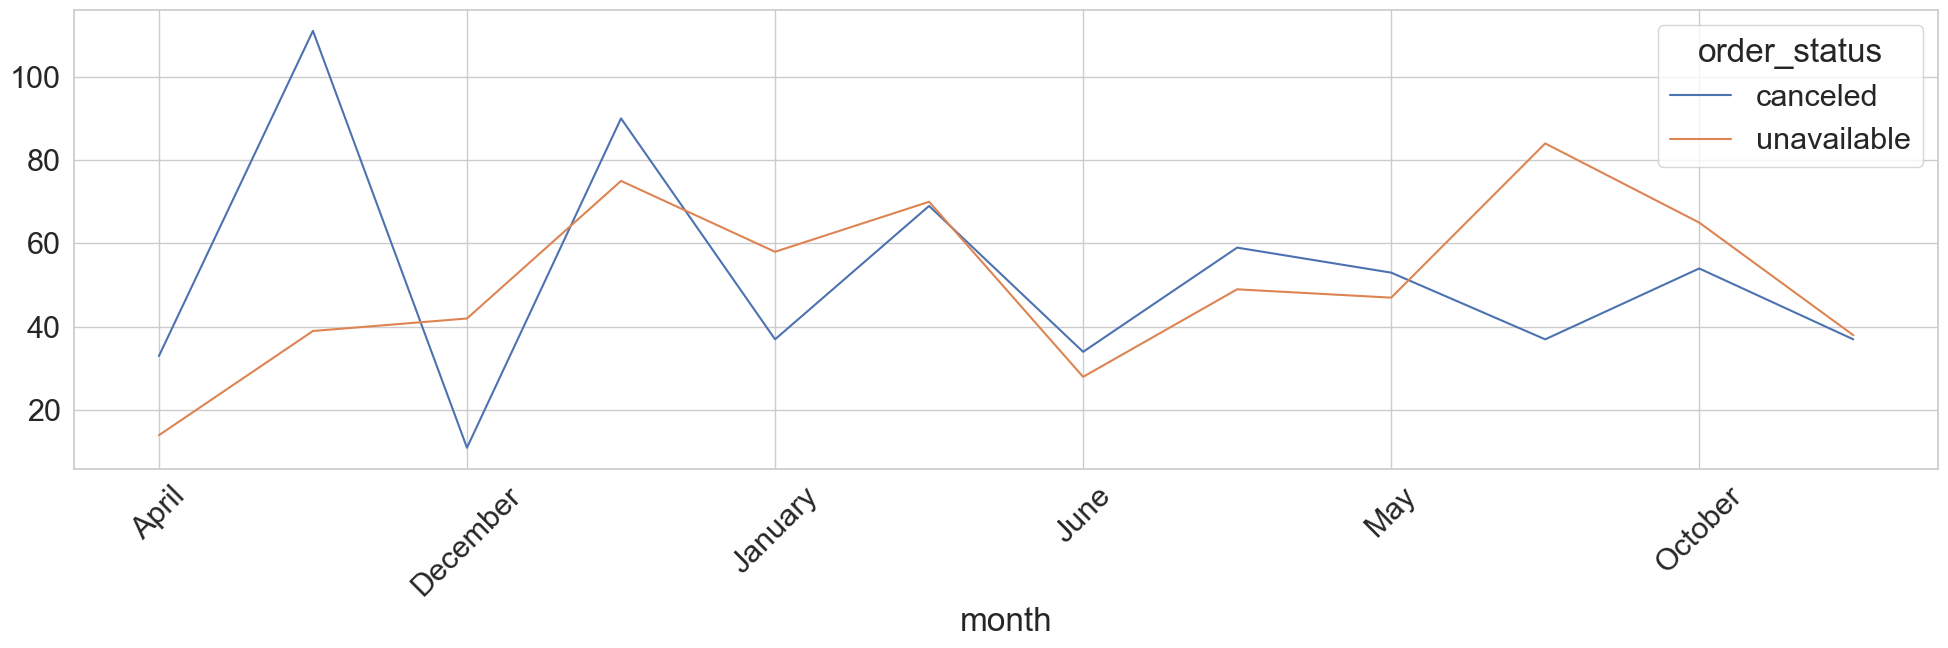

In [142]:
no_delivery_per_month.plot()
plt.xticks(rotation=45)
plt.tight_layout()

In [143]:
# Второй вариант детализации, более информативный:

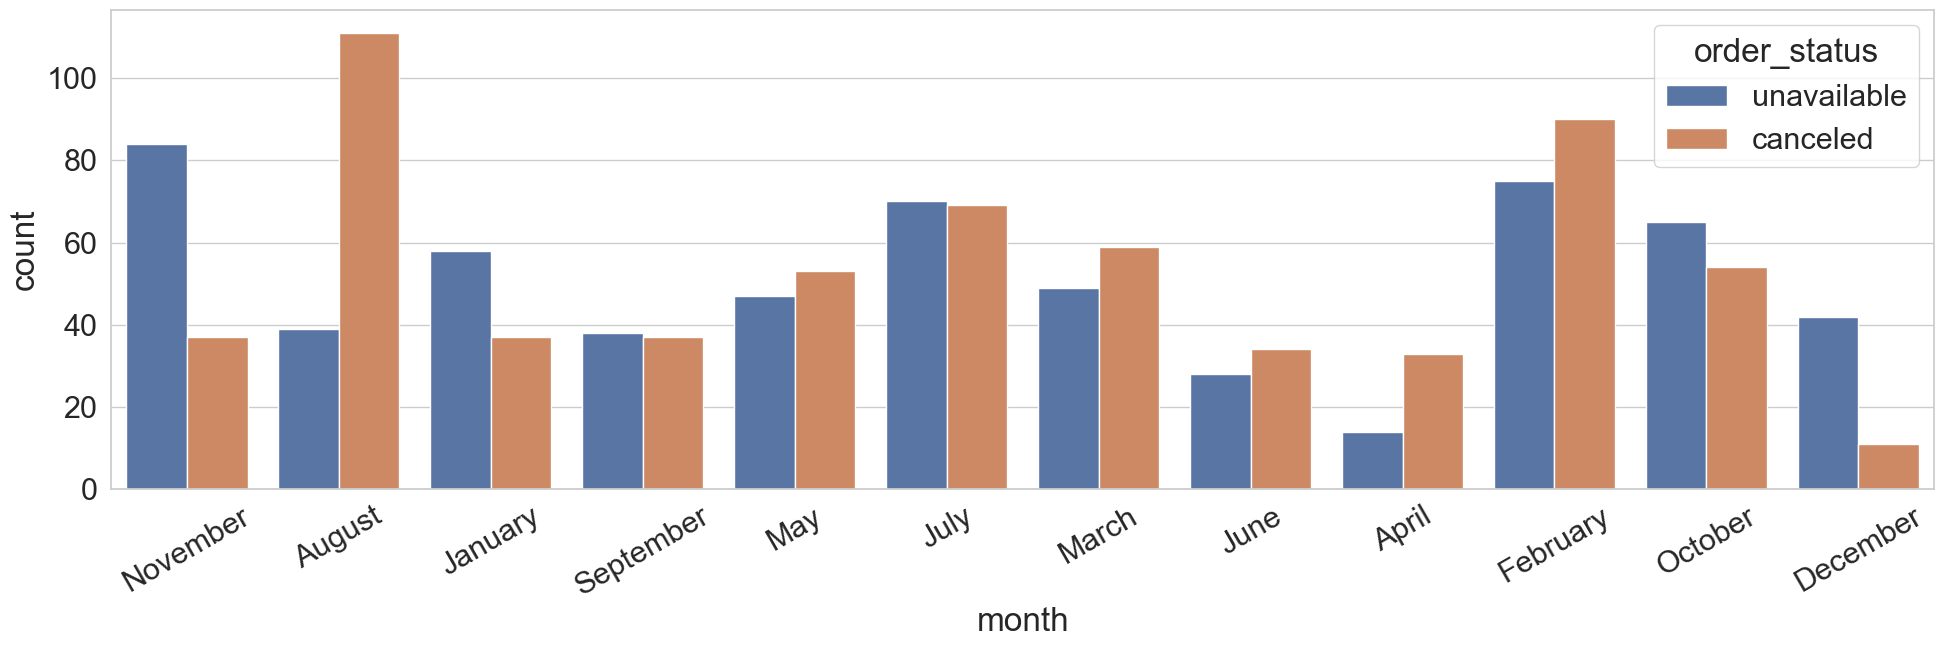

In [144]:
sns.countplot(no_delivery.month, hue = no_delivery.order_status)
plt.xticks(rotation=30)
plt.tight_layout()

## По каждому товару определить, в какой день недели товар чаще всего покупается. 

In [145]:
# Нам нужно для начала сджойнить таблицу заказов с таблицей товаров в заказах чтобы 
# сопоставить купленные товары и время покупки:

In [148]:
order_items

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


In [150]:
orders_product = orders[['order_id','order_purchase_timestamp']] \
    .merge(order_items[['order_id', 'order_item_id', 'product_id']], on = 'order_id')
orders_product

,order_id,order_purchase_timestamp,order_item_id,product_id
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,1,87285b34884572647811a353c7ac498a
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,1,595fac2a385ac33a80bd5114aec74eb8
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,1,aa4383b373c6aca5d8797843e5594415
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,1,d0b61bfb1de832b15ba9d266ca96e5b0
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,1,65266b2da20d04dbe00c5c2d3bb7859e
...,...,...,...,...
112645,63943bddc261676b46f01ca7ac2f7bd8,2018-02-06 12:58:58,1,f1d4ce8c6dd66c47bbaa8c6781c2a923
112646,83c1379a015df1e13d02aae0204711ab,2017-08-27 14:46:43,1,b80910977a37536adeddd63663f916ad
112647,11c177c8e97725db2631073c19f07b62,2018-01-08 21:28:27,1,d1c427060a0f73f6b889a5c7c61f2ac4
112648,11c177c8e97725db2631073c19f07b62,2018-01-08 21:28:27,2,d1c427060a0f73f6b889a5c7c61f2ac4


In [153]:
# Далее навесим на каждую запись день недели:

In [154]:
orders_product = orders_product.assign(day = orders_product.order_purchase_timestamp.dt.day_name())
orders_product

,order_id,order_purchase_timestamp,order_item_id,product_id,day
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,1,87285b34884572647811a353c7ac498a,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,1,595fac2a385ac33a80bd5114aec74eb8,Tuesday
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,1,aa4383b373c6aca5d8797843e5594415,Wednesday
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,1,d0b61bfb1de832b15ba9d266ca96e5b0,Saturday
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,1,65266b2da20d04dbe00c5c2d3bb7859e,Tuesday
...,...,...,...,...,...
112645,63943bddc261676b46f01ca7ac2f7bd8,2018-02-06 12:58:58,1,f1d4ce8c6dd66c47bbaa8c6781c2a923,Tuesday
112646,83c1379a015df1e13d02aae0204711ab,2017-08-27 14:46:43,1,b80910977a37536adeddd63663f916ad,Sunday
112647,11c177c8e97725db2631073c19f07b62,2018-01-08 21:28:27,1,d1c427060a0f73f6b889a5c7c61f2ac4,Monday
112648,11c177c8e97725db2631073c19f07b62,2018-01-08 21:28:27,2,d1c427060a0f73f6b889a5c7c61f2ac4,Monday


In [155]:
# Далее сгруппируем по товару и по дню недели:

In [160]:
product_sales_per_day = orders_product.groupby(['product_id','day'],as_index=False) \
    .agg({"order_id":"count"}) \
    .rename(columns={"order_id":"total_orders"})

product_sales_per_day

,product_id,day,total_orders
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1
...,...,...,...
61225,fffdb2d0ec8d6a61f0a0a0db3f25b441,Friday,1
61226,fffdb2d0ec8d6a61f0a0a0db3f25b441,Sunday,1
61227,fffdb2d0ec8d6a61f0a0a0db3f25b441,Thursday,1
61228,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,2


In [177]:
# Преобразуем наши данные через pivot() :

In [180]:
top_days = product_sales_per_day.pivot(index = 'product_id',columns ='day',values='total_orders' )
top_days.head(10)           

day,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
product_id,,,,,,,
00066f42aeeb9f3007548bb9d3f33c38,NaN,NaN,NaN,1.0,NaN,NaN,NaN
00088930e925c41fd95ebfe695fd2655,NaN,NaN,NaN,NaN,NaN,1.0,NaN
0009406fd7479715e4bef61dd91f2462,NaN,NaN,NaN,NaN,1.0,NaN,NaN
000b8f95fcb9e0096488278317764d19,1.0,NaN,NaN,NaN,NaN,NaN,1.0
000d9be29b5207b54e86aa1b1ac54872,NaN,NaN,NaN,NaN,NaN,1.0,NaN
0011c512eb256aa0dbbb544d8dffcf6e,NaN,NaN,NaN,NaN,1.0,NaN,NaN
00126f27c813603687e6ce486d909d01,NaN,NaN,NaN,2.0,NaN,NaN,NaN
001795ec6f1b187d37335e1c4704762e,NaN,2.0,3.0,NaN,1.0,2.0,1.0
001b237c0e9bb435f2e54071129237e9,NaN,NaN,NaN,NaN,1.0,NaN,NaN


In [178]:
# и найдем имя столбца с максимальным значением для каждого товара

In [181]:
top_days = top_days.idxmax(axis=1) \
    .to_frame() \
    .reset_index()
top_days.head() 

,product_id,0
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Thursday
3,000b8f95fcb9e0096488278317764d19,Friday
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday


## Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. 